# Dataset for RSNA Dataset

In [1]:
from glob import glob #to retrieve array of files in directories
from tqdm import tqdm  #for progress bar
import os
import csv
import random
import pydicom #to read dicom file
import numpy as np
from skimage import io
from skimage import measure
from skimage.transform import resize
import cv2
from pathlib import Path #for path handling
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import shutil

In [4]:
#Creare directories to store the dataset
def make_dirs(out):
    os.makedirs(out)
    os.makedirs(out + "train/")
    os.makedirs(out + "test/")
    
    os.makedirs(out + "train/NORMAL/")
    os.makedirs(out + "train/PNEUMONIA/")
    
    os.makedirs(out + "test/NORMAL/")
    os.makedirs(out + "test/PNEUMONIA/")

In [2]:
output_dir = "proc_input\\covid_data\\" 

sub = pd.read_csv("..\\Input\\Pneumonia\\stage_2_train_labels.csv") 
detail = pd.read_csv("..\\Input\\Pneumonia\\stage_2_detailed_class_info.csv") 

In [3]:
detail.head(6)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [4]:
sub.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


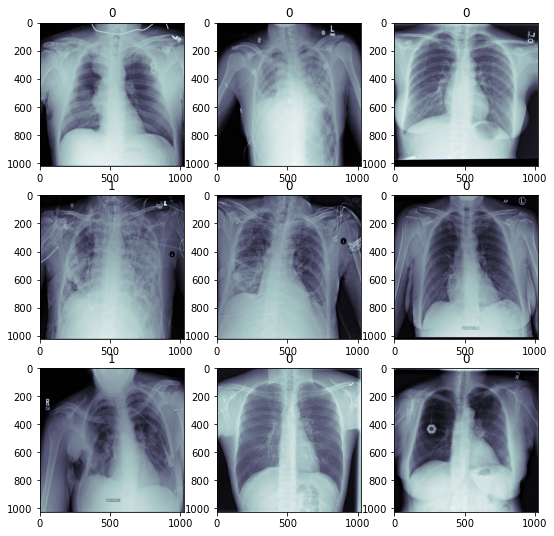

In [5]:
#create a 3x3 subplot
fig, axis = plt.subplots(3,3, figsize = (9,9))

ROOT_PATH = Path("../Input/Pneumonia/stage_2_train_images/") #NEED TO CHANGE!

for i in range(3):
    for j in range(3):
        random_number = random.randint(0, 30227)
        patient_id = sub.patientId.iloc[random_number] #extract PID
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        #store the Target in a variable
        label = sub["Target"].iloc[random_number]
        
        axis[i][j].imshow(dcm, cmap= "bone")
        axis[i][j].set_title(label)

In [9]:
#CONVERT dcm TO jpg

folder_path = ROOT_PATH
images_path = os.listdir(folder_path) #get all of the image

#create a new directory
jpg_path_location = "../Input/Pneumonia/stage_2_train_images2/" #NEED TO CHANGE!
os.makedirs(jpg_path_location) #make new directory
jpg_folder_path = jpg_path_location


#convert all of the dataset to jpd and store in the new location
for n, image in enumerate(tqdm(images_path)):
        ds = pydicom.dcmread(os.path.join(folder_path, image))
        rows = []
        pixel_array_numpy = ds.pixel_array
        image = image.replace('.dcm', '.jpg')
        cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)

100%|██████████| 26684/26684 [07:56<00:00, 56.04it/s]


In [12]:
#Split into NORMAL and PNEUMONIA group
dis_type = detail["class"] #get the class(eg: Normal, Lung Opacity)
dis_name = detail["patientId"] #get the id

name = sub["patientId"]
value = sub["Target"]

name = [name[i]+".jpg" for i in range(len(name))]
dis_name = [dis_name[i]+".jpg" for i in range(len(dis_name))]

img = glob("../Input/Pneumonia/stage_2_train_images2/*") #to get all of the images from the folder
filenames= os.listdir("../Input/Pneumonia/stage_2_train_images2/")

In [13]:
#list.index(element)
normal, pneumonia = [],[]
normal_name, pneumonia_name = [], []

for i in tqdm(range(len(filenames))):
    ind = name.index(filenames[i])
    ind1 = dis_name.index(filenames[i])
    
    #add NORMAL into list
    if(value[ind] == 0 and dis_type[ind] == dis_type[ind] == "Normal"):
        normal.append(img[i])
        normal_name.append(filenames[i])
    
    #add PNEUMONIA into list
    elif(value[ind] ==1 ):
        pneumonia.append(img[i])
        pneumonia_name.append(filenames[i])

100%|██████████| 26684/26684 [00:19<00:00, 1365.32it/s]


In [40]:
from tensorflow.keras.preprocessing import image

normal_image = []
pneumonia_image = []

for i in normal:
    i = i.rsplit("\\", 1)[-1]
    normal_image.append(i)
    
for i in pneumonia:
    i = i.rsplit("\\", 1)[-1]
    pneumonia_image.append(i)

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in tqdm(list_of_filename):
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np("../Input/Pneumonia/stage_2_train_images2/", normal_image)
pnemonia_images = img2np("../Input/Pneumonia/stage_2_train_images2/", pneumonia_image)

100%|██████████| 6012/6012 [06:13<00:00, 16.09it/s]


In [41]:
normal_images

array([[  0.,  13.,  12., ...,   0.,   0.,   0.],
       [  1.,   0.,   0., ...,  93.,  66.,  45.],
       [222., 214., 207., ...,   5.,  11.,  26.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   3.],
       [ 18.,  16.,  16., ..., 112.,  46.,   0.],
       [  3.,   3.,   3., ...,   4.,   6.,  18.]], dtype=float32)

In [42]:
pnemonia_images

array([[  3.,   3.,   3., ..., 145., 144., 136.],
       [ 15.,  17.,  17., ..., 180., 121., 155.],
       [  0.,   0.,  23., ...,   0.,   0.,   0.],
       ...,
       [  3.,   6.,  16., ..., 126., 115.,  76.],
       [ 15.,  31.,  35., ..., 145., 138., 116.],
       [  5.,   5.,   4., ...,   8.,   4.,   4.]], dtype=float32)

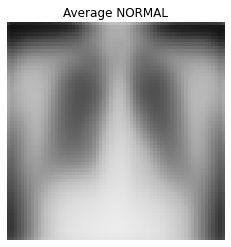

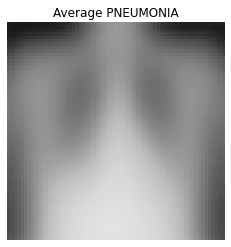

In [54]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

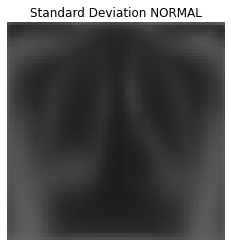

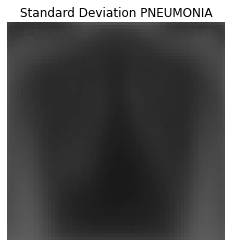

In [62]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pnemonia_images, 'PNEUMONIA')

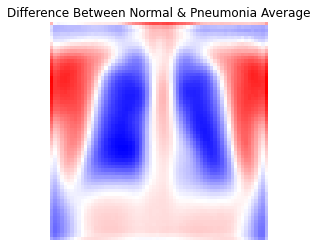

In [63]:
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

Number of PC:  10


100%|██████████| 10/10 [00:00<00:00, 32.68it/s]


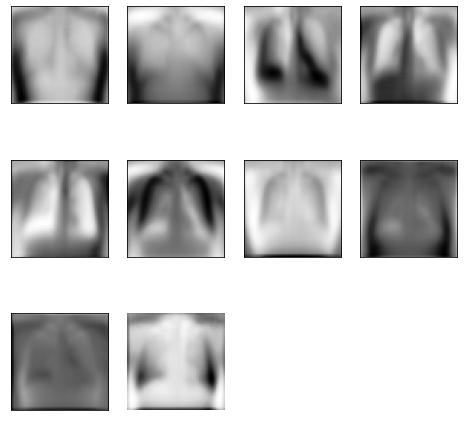

Number of PC:  11


100%|██████████| 11/11 [00:00<00:00, 53.19it/s]


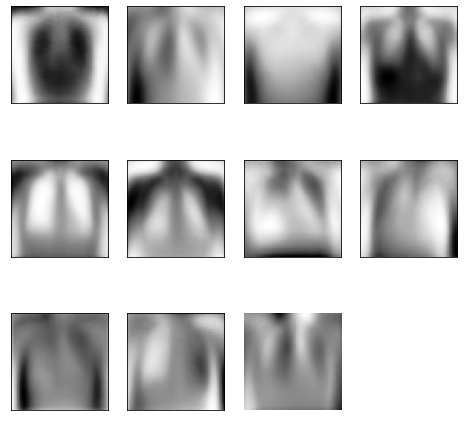

In [46]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in tqdm(range(n)):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_images, 'NORMAL'))
plot_pca(eigenimages(pnemonia_images, 'PNEUMONIA'))

In [5]:
#Data Exploration
#sub.head(6)

In [13]:
sub.head(6)

detail.head(6)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Text(0.5, 1.0, 'Number of Patients Diagnosed with Pneumonia')

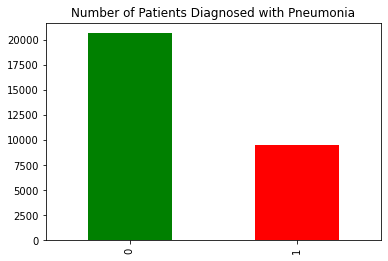

In [24]:
fig, ax = plt.subplots()
c = ['green', 'red']
sub["Target"].value_counts().plot(ax=ax, kind="bar", color= c)
plt.title("Number of Patients Diagnosed with Pneumonia")

Text(0.5, 1.0, 'Number of Patients based on Class')

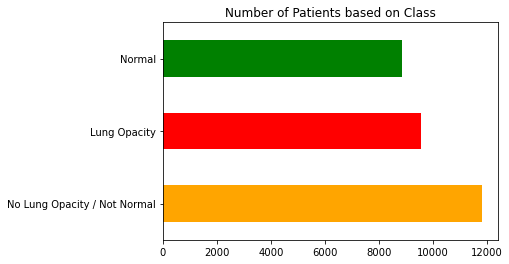

In [19]:
fig, ax = plt.subplots()
c = ['orange', 'red', 'green']
detail["class"].value_counts().plot(ax=ax, kind="barh", color= c)
plt.title("Number of Patients based on Class")

In [12]:
#Shuffle the list
random.shuffle(normal)
random.shuffle(pneumonia)

#90% for training and 10% for testing
normal_train, normal_test = normal[:int(len(normal)*.9)], normal[int(len(normal)*.9):]
pneumonia_train, pneumonia_test = pneumonia[:int(len(pneumonia)*.9)], pneumonia[int(len(pneumonia)*.9):]

In [13]:
print(f"NORMAL TRAIN: {len(normal_train)}")
print(f"NORMAL TEST: {len(normal_test)}\n")
print(f"PNEUMONIA TRAIN: {len(pneumonia_train)}")
print(f"PNEUMONIA TEST: {len(pneumonia_test)}")

NORMAL TRAIN: 7965
NORMAL TEST: 886

PNEUMONIA TRAIN: 5410
PNEUMONIA TEST: 602


In [14]:
try:
    make_dirs(output_dir)
except:
    pass

In [15]:
#Move the image the different folders based on their individual category
for image in tqdm(normal_train):
    shutil.copy(image,output_dir+ "train/NORMAL")
    
for image in tqdm(normal_test):
    shutil.copy(image,output_dir+ "test/NORMAL")

for image in tqdm(pneumonia_train):
    shutil.copy(image,output_dir+ "train/PNEUMONIA")
    
for image in tqdm(pneumonia_test):
    shutil.copy(image,output_dir+ "test/PNEUMONIA")   

100%|██████████| 602/602 [00:01<00:00, 311.49it/s]
